In [1]:
# Uncomment and run this cell if you're on Colab or Kaggle
# !git clone https://github.com/nlp-with-transformers/notebooks.git
# %cd notebooks
# from install import *
# install_requirements()

In [2]:
# hide
from utils import *
setup_chapter()

Using transformers v4.11.3
Using datasets v1.16.1


# Text Generation

<img alt="LM Meta Learning" width="800" caption="During pretraining, language models are exposed to sequences of tasks that can be adapted during inference (courtesy of Tom B. Brown)" src="images/chapter05_lm-meta-learning.png" id="lm-meta-learning"/>

<img alt="Meena" width="300" caption="Meena on the left telling a corny joke to a human on the right (courtesy of Daniel Adiwardana and Thang Luong)" src="images/chapter05_meena.png" id="meena"/>

## The Challenge with Generating Coherent Text

<img alt="Text generation" width="700" caption="Generating text from an input sequence by adding a new word to the input at each step" src="images/chapter05_text-generation.png" id="text-generation"/> 

## Greedy Search Decoding

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [4]:
# Get device
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [5]:
import pandas as pd
pd.set_option('display.max_colwidth', 0)

In [6]:
input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt").input_ids.to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids)
        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0,-1,:]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        
        # Store top choices_per_step token
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx + 1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)
        
pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (8.53%),only (4.96%),best (4.65%),Transformers (4.37%),ultimate (2.16%)
1,Transformers are the most,popular (16.78%),powerful (5.37%),common (4.96%),famous (3.72%),successful (3.20%)
2,Transformers are the most popular,toy (10.63%),toys (7.23%),Transformers (6.60%),of (5.46%),and (3.76%)
3,Transformers are the most popular toy,line (34.38%),in (18.20%),of (11.71%),brand (6.10%),line (2.69%)
4,Transformers are the most popular toy line,in (46.28%),of (15.09%),", (4.94%)",on (4.40%),ever (2.72%)
5,Transformers are the most popular toy line in,the (65.99%),history (12.42%),America (6.91%),Japan (2.44%),North (1.40%)
6,Transformers are the most popular toy line in the,world (69.26%),United (4.55%),history (4.29%),US (4.23%),U (2.30%)
7,Transformers are the most popular toy line in the world,", (39.73%)",. (30.64%),and (9.87%),with (2.32%),today (1.74%)


In [7]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, 
                               do_sample=False)
print(tokenizer.decode(output_greedy.squeeze()))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, from the University of California, Davis, and the University of
Colorado, Boulder, were conducting a study on the Andean cloud forest, which is
home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to
communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able


In [8]:
# max_length = 64
# input_txt = """His name was John and he was a Data Scientist"""
# input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
# output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)
# print(tokenizer.decode(output_greedy.squeeze()))

## Beam Search Decoding

<img alt="Beam search" width="700" caption="Beam search with two beams—the most probable sequences at each timestep are highlighted in blue" src="images/chapter05_beam-search.png" id="beam-search"/> 

In [9]:
0.5 ** 1024

5.562684646268003e-309

In [10]:
import numpy as np

sum([np.log(0.5)] * 1024)

-709.7827128933695

In [11]:
import torch.nn.functional as F

Please note that our model predics the "following" word given an input sequence. Therefore given an input sequence $x_1, x_2, ...,x_n$ and logits $logit_1, logit_2, ..., logit_n$, $logit_1$ should be associated to the input token $x_2$ (and not $x_1$) as such logit refers to the (kind of) probability of the next token after token $x_1$.

In [12]:
with torch.no_grad():
    output = model(output_greedy)
    logits = output.logits[:,:-1,:]
    log_probs = F.log_softmax(logits, dim=-1)
    labels = output_greedy[:,1:]

With `torch.gather()` I will select only the log probabilities of the actual labels generated by the model. Please note that I have to `unsqueeze` the labels as I need an extra dimension to retrieve the log probability from the `log_probs` tensor.

In [13]:
logp_label = torch.gather(log_probs, dim=2, index=labels.unsqueeze(2))

In [14]:
logp_label.squeeze()[46] == F.log_softmax(output.logits, dim=-1)[:,46,torch.argmax(output.logits[0,46,:], dim=-1)]

tensor([True], device='cuda:0')

In [15]:
# Let's do a simple check
logp_label[0,0,0] == log_probs[0,0,labels[0,0]]
print(logp_label[0,0,0])
print(log_probs[0,0,labels[0,0]])

tensor(-2.7776, device='cuda:0')
tensor(-2.7776, device='cuda:0')


Let's now calculate the log-probability of the sequence as the sum of all log-probabilities. We will ignore the log-probabilities of the input sequence.

In [16]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

Please note I have modified the `sequence_logprob` function and changed the slicing of `log_probs` into `log_probs[:, input_len-1:]`. This is because of the way indexing works in Python (0-based) and the fact that logits refer to the n+1 word. In this specific case, we know that:
* input text is made of 47 tokens (index from 0 to 46)
* logits for the entire output sequence refer to 128 tokens. Logits at index 0 actually refer to the "following" token (i.e., the *second* token in the sequence, if we start counting token from 1)
* the first model-generated token is token number 48 (as the first 47 tokens come from the promt). Token number 48, in Python, would be that at index 47. However, because logits are "shifted", we need to take logits at index 46 (the token at index 47 (0-based indexing), corresponding to token number 48 (starting token count from 1))

In [17]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len-1:])
    return seq_log_prob.cpu().numpy()

In [18]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, from the University of California, Davis, and the University of
Colorado, Boulder, were conducting a study on the Andean cloud forest, which is
home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to
communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able

log-prob: -88.66


In [19]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, 
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery of the unicorns was made by a team of scientists from the
University of California, Santa Cruz, and the National Geographic Society.


The scientists were conducting a study of the Andes Mountains when they
discovered a herd of unicorns living in a remote, previously unexplored valley,
in the Andes Mountains. Even more surprising to the researchers was the fact
that the unicorns spoke perfect English

log-prob: -56.45


In [20]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, 
                             do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery was made by a team of scientists from the University of
California, Santa Cruz, and the National Geographic Society.

According to a press release, the scientists were conducting a survey of the
area when they came across the herd. They were surprised to find that they were
able to converse with the animals in English, even though they had never seen a
unicorn in person before. The researchers were

log-prob: -94.35


## Sampling Methods

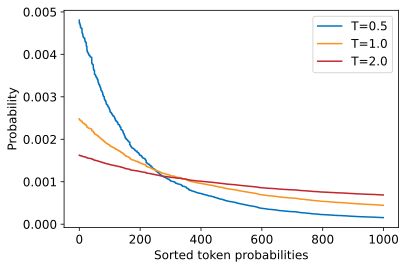

In [21]:
#hide_input

#id temperature
#alt Token probabilities as a function of temperature
#caption Distribution of randomly generated token probabilities for three selected temperatures
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

In [22]:
# hide
torch.manual_seed(42);

In [23]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


Banglington station line protagonist Bree Miller woke nostalgiate Rider
Faithrometta Bluial Mju Agreement generously brings Kashun Dracozin Auctuz
Doraelque Pumpkin meremavern stall class inequariansiamond disse * Runew
Endurance whilst spear secured majorityb zo coachinginventoryatelletonwarming
instinctivelypres Wrestling chargesThingsCooldown Guillard Ty physicianness
Kimvillecurrently exhaustionSince at aff da temporacia MD RIPAbout iter


In [24]:
# hide
torch.manual_seed(42);

In [25]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The scientists were searching for the source of the mysterious sound, which was
making the animals laugh and cry.


The unicorns were living in a remote valley in the Andes mountains

'When we first heard the noise of the animals, we thought it was a lion or a
tiger,' said Luis Guzman, a researcher from the University of Buenos Aires,
Argentina.


'But when


In [26]:
torch.manual_seed(42)

In [27]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=0.2, top_k=0, no_repeat_ngram_size=2)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, from the University of California, Davis, and the National
Geographic Society, were able to determine that these unicorn herders were the
descendants of a group of ancient humans who lived in what is now the Peruvian
Andean highlands. The researchers believe that this ancient group was part of
the first human migration out of Africa, which occurred approximately 100,000
years ago.

"The


## Top-k and Nucleus Sampling

In [28]:
# hide
torch.manual_seed(42);

In [29]:
# hide
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [30]:
# hide
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

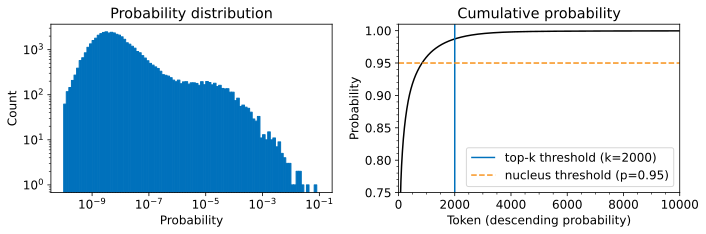

In [33]:
# hide_input

#id distribution
#alt Probability distribution of next token prediction.
#caption Probability distribution of next token prediction (left) and cumulative distribution of descending token probabilities

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

In [34]:
# hide
torch.manual_seed(42);

In [35]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The wild unicorns roam the Andes Mountains in the region of Cajamarca, on the
border with Argentina (Picture: Alamy/Ecole Nationale Supérieure d'Histoire
Naturelle)

The researchers came across about 50 of the animals in the valley. They had
lived in such a remote and isolated area at that location for nearly a thousand
years that


In [36]:
# hide
torch.manual_seed(42);

In [37]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The scientists studied the DNA of the animals and came to the conclusion that
the herd are descendants of a domesticated horse called the Auroch. The
researchers believe that the Auroch may have originally lived in the Andes and
later migrated to the United States.


The animals were found in an area of the valley called the Las Pajas or 'Mounts
of the Sky'.





In [38]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_k=50,
                             top_p=0.75)
print(tokenizer.decode(output_topp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


Scientists from the University of California, Davis and the Universidad de
Concepción in Chile have been conducting a research project in the remote area
of the Andes Mountains for the past three years, but it was only last year that
they were able to record the unicorn's first sound.


The researchers, led by Dr. Richard Litt, had been following the movements of
the herd for more


## Which Decoding Method Is Best?

## Conclusion